In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import xgboost as xgb

In [17]:
df = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [18]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [19]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Exited and Non-Exited Customers by Geography:
Exited        0    1
Geography           
France     4204  810
Germany    1695  814
Spain      2064  413


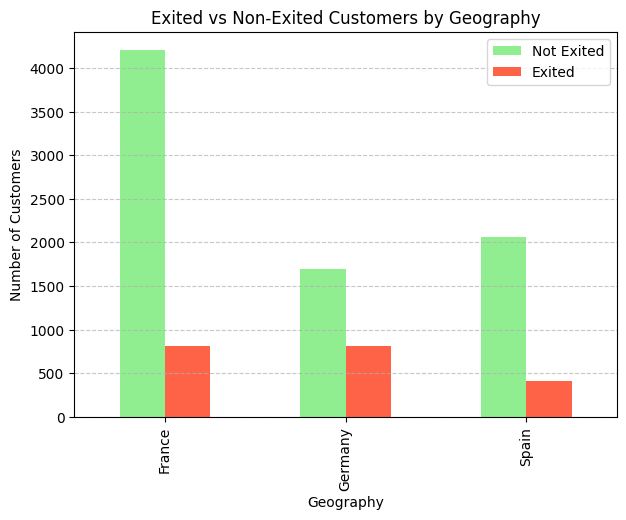

In [21]:
# Group by geography and exited status
geo_exit_counts = df.groupby(['Geography', 'Exited']).size().unstack(fill_value=0)

print("Exited and Non-Exited Customers by Geography:")
print(geo_exit_counts)

geo_exit_counts.plot(kind='bar', figsize=(7, 5), color=['lightgreen', 'tomato'])
plt.title('Exited vs Non-Exited Customers by Geography')
plt.xlabel('Geography')
plt.ylabel('Number of Customers')
plt.legend(['Not Exited', 'Exited'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [22]:
# Add engineered features
df['Balance_to_Salary'] = df['Balance'] / (df['EstimatedSalary'] + 1)
df['Tenure_to_Age'] = df['Tenure'] / df['Age']
df['Product_Utilization'] = df['NumOfProducts'] / (df['Tenure'] + 1)
df['Active_Credit_User'] = df['IsActiveMember'] * df['HasCrCard']
df['High_Value'] = (df['Balance'] > df['Balance'].median()).astype(int)
df['Credit_Age'] = df['CreditScore'] * df['Age']

# Age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100],
                         labels=['18–30', '31–40', '41–50', '51–60', '60+'])

# Target encoding for Geography
geo_churn_rate = df.groupby('Geography')['Exited'].mean()
df['Geo_Churn_Rate'] = df['Geography'].map(geo_churn_rate)

df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,EstimatedSalary,Exited,Balance_to_Salary,Tenure_to_Age,Product_Utilization,Active_Credit_User,High_Value,Credit_Age,Age_Group,Geo_Churn_Rate
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,...,101348.88,1,0.000000,0.047619,0.333333,1,0,25998,41–50,0.161548
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,...,112542.58,0,0.744670,0.024390,0.500000,0,0,24928,41–50,0.166734
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,...,113931.57,1,1.401362,0.190476,0.333333,0,1,21084,41–50,0.161548
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,...,93826.63,0,0.000000,0.025641,1.000000,0,0,27261,31–40,0.161548
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,...,79084.10,0,1.587035,0.046512,0.333333,1,1,36550,41–50,0.166734


In [23]:
selected_features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
    'IsActiveMember', 'Balance_to_Salary', 'Tenure_to_Age', 'Product_Utilization',
    'Active_Credit_User', 'High_Value', 'Credit_Age', 'Geo_Churn_Rate'
]
X = df[selected_features]
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],     # Regularization strength (inverse)
    'penalty': ['l1', 'l2'],          # Type of regularization
    'solver': ['liblinear', 'saga']   # Solvers that support both L1 & L2
}
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test_scaled)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.48857106066528555

Test Accuracy: 0.7045

Confusion Matrix:
 [[1119  474]
 [ 117  290]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.38      0.71      0.50       407

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000



In [26]:
dt = DecisionTreeClassifier(random_state=42, class_weight={0:100,1:1})
param_grid = {
    'max_depth': [3, 5, 7, 10, None],        # Limit tree depth to prevent overfitting
    'min_samples_split': [2, 5, 10, 20],     # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],       # Minimum samples at a leaf node
    'criterion': ['gini', 'entropy']         # Split quality measure
}
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1',     # focus on minority class (Exited=1)
    cv=10,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)
best_dt = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
y_pred = best_dt.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 10 folds for each of 160 candidates, totalling 1600 fits
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test Accuracy: 0.8185

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1593
           1       0.57      0.46      0.51       407

    accuracy                           0.82      2000
   macro avg       0.72      0.69      0.70      2000
weighted avg       0.81      0.82      0.81      2000



In [27]:
rf = RandomForestClassifier(random_state=42, class_weight={0:100,1:1})
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}
rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,           # number of random combinations to try
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
rand_search.fit(X_train_scaled, y_train)
best_rf = rand_search.best_estimator_
print("Best Parameters:", rand_search.best_params_)
y_pred = best_rf.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}
Test Accuracy: 0.8645

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.76      0.48      0.59       407

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.86      0.85      2000



In [28]:
z = (((y_train==0).sum() * (y_train==1).sum())/((y_train==0).sum() + (y_train==1).sum()))
z1=(y_train==0).sum() / (y_train==1).sum()

In [29]:

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight = z1,  # handle imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}
rand_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
rand_search.fit(X_train_scaled, y_train)
best_xgb = rand_search.best_estimator_
print("Best Parameters:", rand_search.best_params_)
y_pred = best_xgb.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
Test Accuracy: 0.821

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1593
           1       0.55      0.65      0.60       407

    accuracy                           0.82      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.83      0.82      0.83      2000

